In [1]:
%%writefile /kaggle/working/circuit_extract.py
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_circuit_masks(circuit, binarize=False):
    # 1. Extract and process masks
    # We zip with the model chain to know what layer type corresponds to what mask
    layers_data = []
    
    with torch.no_grad():
        for i, (mask_module, layer_module) in enumerate(zip(circuit.masks, circuit.model.chain)):
            name = str(layer_module).split('(')[0]
            if "ReLU" in name or "MaxPool" in name:
                continue

            mask = mask_module.mask.detach().cpu()
            temp = mask_module.temperature
            
            if binarize:
                prob = (mask > 0).float()
            else:
                prob = torch.sigmoid(mask / temp)
            
            layers_data.append({
                "index": i,
                "name": str(layer_module).split('(')[0], # e.g. Conv2d, ReLU
                "prob": prob,
                "type": "conv" if prob.dim() > 1 else ("fc" if prob.numel() < 100 else "flat")
            })

    # 2. Filter data for plotting
    conv_layers = [l for l in layers_data if l["type"] == "conv"]
    fc_layers = [l for l in layers_data if l["type"] == "fc"]

    # 3. Setup Figure
    # We create a Grid with 2 Rows: Top for Conv, Bottom for FC
    num_conv = len(conv_layers)
    num_fc = len(fc_layers)
    
    # If no layers of a certain type exist, handle gracefully
    if num_conv == 0 and num_fc == 0:
        print("No masks found to visualize.")
        return

    # Create figure with dynamic width based on number of layers
    total_cols = max(num_conv, num_fc)
    fig = plt.figure(figsize=(max(4, total_cols * 2.5), 10))
    fig.suptitle(f'Circuit Signal Propagation\n(Lighter = Kept, Darker = Pruned)', fontsize=16)

    # --- Plot Convolutional Layers (Row 1) ---
    if num_conv > 0:
        # Create subplots for the first row
        # usage: subplot(rows, cols, index)
        for idx, layer in enumerate(conv_layers):
            ax = fig.add_subplot(2, num_conv, idx + 1)
            
            # Calculate mean activation per channel: (C, H, W) -> (C, 1)
            # dim=list(range(1, prob.dim())) usually [1, 2] for (C, H, W)
            spatial_dims = list(range(1, layer["prob"].dim()))
            channel_activity = layer["prob"].mean(dim=spatial_dims).numpy().reshape(-1, 1)
            
            sns.heatmap(
                channel_activity, 
                ax=ax, 
                cmap="viridis", 
                vmin=0, vmax=1, 
                cbar=(idx == num_conv - 1), # Only show colorbar on last plot
                xticklabels=False,
                yticklabels=True
            )
            
            ax.set_title(f'L{layer["index"]}: {layer["name"]}\n(Channels: {channel_activity.shape[0]})')
            ax.set_ylabel('Channel Index')
            ax.set_xlabel('Avg Activity')

    # --- Plot Fully Connected Layers (Row 2) ---
    if num_fc > 0:
        # Center the FC plots if there are fewer than Conv plots
        start_offset = 0
        
        for idx, layer in enumerate(fc_layers):
            # Plot in the second row
            ax = fig.add_subplot(2, num_fc, num_fc + idx + 1)
            
            neuron_activity = layer["prob"].numpy().reshape(-1, 1)
            
            sns.heatmap(
                neuron_activity, 
                ax=ax, 
                cmap="magma", # Different colormap to distinguish FC
                vmin=0, vmax=1, 
                cbar=(idx == num_fc - 1),
                xticklabels=False,
                yticklabels=True,
                annot=True, # Show numbers for FC neurons since they are few
                fmt=".2f"
            )
            
            ax.set_title(f'L{layer["index"]}: {layer["name"]}\n(Neurons: {neuron_activity.shape[0]})')
            ax.set_ylabel('Neuron Index')
            ax.set_xlabel('Activity')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
    
    output_path = "circuit_visualization.png"
    plt.savefig(output_path)
    plt.show()
    print(f"\nVisualization saved to {output_path}")

def analyze_disconnected_unmasked(circuit, threshold_weight=0.1, threshold_mask=0.5):
    """
    Identifies and visualizes 'Zombie' units: Channels/Neurons that are 
    kept active by the mask (unmasked) but have near-zero weights (disconnected).
    """
    print(f" Analysis: Disconnected vs Unmasked ")
    
    zombies = []

    # Based on inference.CNN structure:
    weight_layers = {
        0: "Conv 1",
        3: "Conv 2",
        7: "Classifier (Linear)"
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle("Weight Magnitude vs. Mask Activation\n(Top-Left Quadrant = Disconnected yet Unmasked)", fontsize=16)

    for idx, (layer_idx, layer_name) in enumerate(weight_layers.items()):
        # 1. Get Mask Data
        # Mask is on the OUTPUT of the layer.
        mask_module = circuit.masks[layer_idx]

        # Calculate Mean Mask Value per Channel/Unit
        with torch.no_grad():
            mask_val = torch.sigmoid(mask_module.mask / mask_module.temperature).cpu()
            
            if mask_val.dim() > 1: # Conv Layer: (C, H, W) -> Average over H,W to get (C)
                mask_scores = mask_val.mean(dim=[1, 2])
            else: # Linear Layer: (C)
                mask_scores = mask_val

            # 2. Get Weight Data
            layer_module = circuit.model.chain[layer_idx]
            weights = layer_module.weight.data.cpu() # Shape: (Out, In, k, k) or (Out, In)
            
            # Calculate L2 Norm of filters producing these outputs
            # Flatten all dims except the first (Out Channels)
            weight_norms = weights.view(weights.shape[0], -1).norm(dim=1)

        # 3. Identify Zombies
        # Unmasked (Mask > 0.5) AND Disconnected (Weight < threshold)
        is_unmasked = mask_scores > threshold_mask
        is_disconnected = weight_norms < threshold_weight
        zombie_indices = torch.where(is_unmasked & is_disconnected)[0]
        
        if len(zombie_indices) > 0:
            zombies.append(f"{layer_name}: {len(zombie_indices)} units (Indices: {zombie_indices.tolist()})")

        # 4. Plot
        ax = axes[idx]
        ax.scatter(weight_norms, mask_scores, alpha=0.6, c=mask_scores, cmap='viridis')
        
        # Add "Zombie Zone" highlighting
        ax.axhspan(ymin=threshold_mask, ymax=1.1, xmin=0, xmax=threshold_weight/max(weight_norms), 
                   color='red', alpha=0.1, label='Zombie Zone')
        
        ax.set_title(f"{layer_name}\n({weights.shape[0]} units)")
        ax.set_xlabel("Weight L2 Norm (Connection Strength)")
        ax.set_ylabel("Mask Probability (Keep Strength)")
        ax.grid(True, linestyle='--', alpha=0.5)
        
        # Annotate specific points if they are zombies
        for z_idx in zombie_indices:
             ax.text(weight_norms[z_idx], mask_scores[z_idx], str(z_idx.item()), fontsize=8)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    print("Potential 'Zombie' Units found:")
    for z in zombies:
        print(f" - {z}")
    if not zombies:
        print(" - None found (All kept units have significant weights)")
        
    return zombies

def analyze_circuit_overlay(circuits_dict, layer_idx=3):
    """
    Visualizes the intersection of neurons across multiple class circuits.
    
    
    circuits_dict: {class_label: circuit_model}
    layer_idx: layer -> analyze
    """
    print(f" Analysis: Circuit Overlay (Layer {layer_idx}) ")

    labels = list(circuits_dict.keys())
    
    # 1. Collect Masks
    mask_collection = []
    
    for label, circ in circuits_dict.items():
        with torch.no_grad():
            mask_module = circ.masks[layer_idx]
            # Get binary mask decision (soft > 0.5) or raw probability
            prob = torch.sigmoid(mask_module.mask / mask_module.temperature).cpu()
            
            # Collapse spatial dims if conv layer to get Channel Importance
            if prob.dim() > 1:
                # Average over spatial dimensions to get score per channel
                # Shape: (Num_Channels)
                channel_score = prob.mean(dim=[1, 2])
            else:
                channel_score = prob
                
            mask_collection.append(channel_score.numpy())

    # Shape: (Num_Classes, Num_Channels)
    heatmap_data = np.stack(mask_collection)
    
    # 2. Visualize Overlay
    plt.figure(figsize=(12, max(4, len(labels)/2)))
    
    # Plot heatmap
    ax = sns.heatmap(
        heatmap_data, 
        yticklabels=[f"Class {l}" for l in labels],
        xticklabels=True,
        cmap="magma", 
        vmin=0, vmax=1,
        annot=False
    )
    
    plt.title(f"Neuron Commonality Map - Layer {layer_idx}\n(Vertical stripes = Shared Features)")
    plt.xlabel("Neuron/Channel Index")
    plt.ylabel("Circuit Class")
    plt.show()
    
    # 3. Compute Intersection Statistics
    # Binarize to find strict overlap
    binary_map = heatmap_data > 0.5
    
    # Sum down the columns (how many classes use channel X?)
    usage_counts = binary_map.sum(axis=0)
    
    shared_neurons = np.where(usage_counts == len(labels))[0]
    unique_neurons = np.where(usage_counts == 1)[0]
    
    print(f"Layer {layer_idx} Stats:")
    print(f" - Total Neurons/Channels: {len(usage_counts)}")
    print(f" - Universally Shared Neurons (Used by all): {len(shared_neurons)} indices: {shared_neurons}")
    print(f" - Class-Specific Neurons (Used by exactly 1): {len(unique_neurons)}")
    
    return shared_neurons

Writing /kaggle/working/circuit_extract.py


In [2]:
%%writefile /kaggle/working/train.py
import random
from functools import partial

import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
import inference
import typing


from torch import nn
from torch.utils.data import DataLoader, Subset


def acc(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    model.to(device)

    correct = 0
    total = 0
    with torch.no_grad():
        for X,Y in loader:
            X, Y = X.to(device), Y.to(device)
            logits = model(X)
            correct += torch.sum(logits.argmax(dim=1) == Y)
            total += len(Y)

    return correct/total

#added a min_alive parameter which retains some amout of neurons in each filter
def topk(x, k, abs=False, dim=None, min_alive=4):   
    if k >= x.numel(): k = x.numel()

    topk_fn = partial(torch.topk, sorted=False)
    
    if dim is None or len(x.shape)==1:  
        x = x.flatten()
        topk_fn = partial(topk_fn, dim=0)
    else:
        sz = x.numel() // x.shape[dim]
        assert k % x.shape[dim] == 0

        def _topk_fn(x, k, topk_fn):
            k = max(min_alive, k//x.shape[dim])
            inds = torch.arange(x.numel()).reshape(x.shape)
            inds = inds.transpose(dim, 0).reshape(x.shape[dim], -1)
            vals = x.transpose(dim, 0).reshape(x.shape[dim], -1)
            vals, i = topk_fn(vals, dim=1, k=k, sorted=False)
            inds = torch.gather(inds, 1, i).flatten()
            
            return vals, inds

        topk_fn = partial(_topk_fn, topk_fn=topk_fn)

    if abs:
        _, inds = topk_fn(x.abs(), k)
        vals = x.flatten()[inds]
    else:
        vals, inds = topk_fn(x, k)

    return vals, inds


def apply_topk_(model, pfrac, min_alive=5):
  
    with torch.no_grad():
        for pn, p in model.named_parameters():
            k = int(pfrac * p.numel())
           
            if type(p) == nn.Conv2d:
                #we prune per filter 
                _, indices = topk(p.data.abs(), k=k, abs=False, dim=0, min_alive=min_alive)
                
            else:
                #we prune globally
                _, indices = topk(p.data, k=k, abs=False, dim=None, min_alive=min_alive)
            
            mask = torch.zeros_like(p.data.flatten(), dtype=torch.bool)
            mask.index_fill_(0, indices, 1)
            mask = mask.view_as(p.data)
            p.data[~mask] = 0 


def calculate_mean_activations(model, loader, device):
    model.eval()
    model.to(device)

    dummy_input, _ = next(iter(loader))
    dummy_input = dummy_input[0:1].to(device)
    acts = []

    with torch.no_grad():
        x = dummy_input
        for module in model.chain:
            x = module(x)
            acts.append(torch.zeros_like(x))

        count = 0
        for X, _ in loader:
            X = X.to(device)
            bs = X.shape[0]
            count += bs
            for i, module in enumerate(model.chain):
                X = module(X)
                acts[i] += X.sum(dim=0)
    
    return [act / count for act in acts]

#added a resampler
from typing import Any, Sequence

def resampler(labels: Sequence[Any], class_probs: dict[Any, float], n: int) -> list[int]:
    classes = np.unique(labels)

    class_idxs = {cls: [] for cls in classes}

    for idx, cls in enumerate(labels):
        class_idxs[cls].append(idx)
    
    for v in class_idxs.values():
        random.shuffle(v)

    ret: list[int] = []
    for cls in classes:
        idxs, prob = class_idxs[cls], class_probs[cls]
        ret += idxs[:int(prob * n)]

    return ret

def load_dataset(ds_name):
    transform=v2.Compose([
            v2.ToTensor(),
            v2.Normalize((0.1307,), (0.3081,))
        ])
    if ds_name == "mnist-baseline":
    
        trainset = torchvision.datasets.MNIST(root="./data",train=True, transform=transform, download=True)
        testset  = torchvision.datasets.MNIST(root="./data",train=False, transform=transform, download=True)

    elif "mnist-circuit" in ds_name:
        label = int(ds_name[-1])
        target_transform = lambda x: x==label
      
        testset  = torchvision.datasets.MNIST(root="./data",train=False, transform=transform, download=True, target_transform=target_transform)


          
        trainset_super = torchvision.datasets.MNIST(
            root="./data", 
            train=True, 
            transform=transform, 
            download=True
        )

        labs = (trainset_super.targets == label) 
        probs = {0: 0.5, 1: 0.5}

        train_idxs = resampler(labs.tolist(), probs, n=10000)
        trainset = Subset(trainset_super, train_idxs)
        
        # trainset = torchvision.datasets.MNIST(root="./data",train=True, transform=transform, download=True, target_transform=target_transform)
        # testset  = torchvision.datasets.MNIST(root="./data",train=False, transform=transform, download=True, target_transform=target_transform)
    
    elif "mnist-class" in ds_name:
      
        label = int(ds_name[-1])
        dataset = torchvision.datasets.MNIST(root="./data",transform=transform, download=True)
        train_idxs = torch.arange(len(dataset.train_labels))[dataset.train_labels == label]
        test_idxs  = torch.arange(len(dataset.test_labels))[dataset.test_labels == label]

        trainset = Subset(dataset, train_idxs)
        testset = Subset(dataset, test_idxs)


    elif "custom" in ds_name:
        label = int(ds_name[-1])
      
        testset  = torchvision.datasets.MNIST(root="./data",train=False, transform=transform, download=True)

        trainset_super = torchvision.datasets.MNIST(
            root="./data", 
            train=True, 
            transform=transform, 
            download=True
        )

        labs = trainset_super.targets
        probs = {}
        for i in range(10):
            probs[i] = 0.5/9
        probs[label] = 0.5

        train_idxs = resampler(labs.tolist(), probs, n=10000)
        trainset = Subset(trainset_super, train_idxs)

    
    else:
        raise NotImplementedError
        


    trainloader = DataLoader(trainset, batch_size=512, shuffle=True, pin_memory=True,num_workers=4)
    testloader = DataLoader(testset, batch_size=512, shuffle=False, pin_memory=True,num_workers=4)

    return trainloader, testloader

# def finetune(
#     model: nn.Module,
#     num_classes: int,
#     lr: float,
#     b1: float,
#     b2: float,
#     ds_name: str,
#     eps : float,
#     epochs : int,
#     device : str,
#     seed: int = 0,
# ):

#     for p in model.parameters():
#         p.requires_grad = False

#     in_features = model.fc.in_features
#     model.fc = torch.nn.Linear(in_features, num_classes)
#     model.fc.requires_grad = True

#     all_params = list(model.fc.parameters())

#     train_model(model, lr, b1, b2, None, ds_name, eps, epochs, device, all_params, seed)


def train_model(
    model: nn.Module,
    lr: float,
    b1: float,
    b2: float,
    # pfrac: float | None,
    ds_name: str,
    eps : float,
    epochs : int,
    device : str,
    scheduler: typing.Callable[[int], float] | None,
    all_params: list = None,
    seed: int = 0,
):
  
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    if all_params is None: all_params = list(model.parameters())
    betas = (b1, b2)

    optimizer = torch.optim.Adam(
        all_params,
        lr=lr,
        eps=eps,
        betas=betas,
        fused=True,
    )

    trainloader, testloader = load_dataset(ds_name)

    n_params = sum(p.numel() for p in model.parameters())
    n_params_wd = sum(p.numel() for p in model.parameters() if len(p.shape) > 1)

    print("n_params", n_params, "n_params_wd", n_params_wd)

    model.train()
    model.to(device)
    print(device)
    for epoch in range(epochs):
        for X, Y in trainloader:
            X, Y = X.to(device), Y.to(device)

            optimizer.zero_grad()
            logits = model(X)
            loss = F.cross_entropy(logits, Y)
            loss.backward()
            optimizer.step()

            if scheduler is not None:
                pfrac = scheduler(epoch+1) 
                apply_topk_(
                    model,
                    pfrac=pfrac,
                )


            if pfrac is not None:    
                apply_topk_(
                    model,
                    pfrac=pfrac,
                )

        if epoch % 1 == 0:
            print(f'Epoch {epoch} | Train Acc: {acc(model, trainloader, device):.4f} | Test Acc: {acc(model, testloader, device):.4f}')



def extract_circuit(
        model:nn.Module, 
        lr: float, 
        b1: float, 
        b2: float, 
        ds_name: str, 
        eps: float, 
        epochs: int, 
        device: torch.device = 'cpu', 
        l0_lambda: float = 0.0, 
        temperature:float =0.3,
        mean_ablation: bool = True,
        seed=0
    ):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    model.eval()
    model.to(device)

   
    
    trainloader, testloader = load_dataset(ds_name)
    inp_shape = next(iter(trainloader))[0][0].shape # (C, H, W)


    
    print("Calculating mean activations...")
    mean_activations = calculate_mean_activations(model, load_dataset("mnist-baseline")[0], device)
    
    print("Initializing Circuit...")
    circuit = inference.Circuit(model, inp_shape, mean_activations, temperature, mean_ablation)
    circuit.to(device)

    print("Initializing Optimizer...")
    optimizer = torch.optim.Adam(circuit.parameters(), lr=lr, eps=eps, betas=(b1, b2))

   
    print(f"Extracting Circuit (L0 Lambda={l0_lambda})...")
    for epoch in range(epochs):
        circuit.train() 
        circuit.model.eval()
        total_loss_avg = 0
        
        for X, Y in trainloader:

            X, Y = X.to(device), Y.to(device)

            optimizer.zero_grad()
            logits = circuit(X)
            
            ce_loss = F.cross_entropy(logits, Y)
            epsilon = 1e-4
            l0_loss = circuit.total_l0_loss() / circuit.total_params +epsilon
            
            loss = ce_loss + l0_lambda * l0_loss
            
            loss.backward()
            optimizer.step()
            circuit.clamp_masks()
            
            total_loss_avg += loss.item()

        if epoch % 1 == 0:
            mask_avg = circuit.debug_stats()
            print(f'Epoch {epoch} | Loss: {total_loss_avg/len(trainloader):.4f} | Avg Mask: {mask_avg:.3f} | Total Non-Zero: {circuit.total_l0_loss()} | | Circuit Acc: {acc(circuit, testloader, device):.4f}')

    return circuit

Writing /kaggle/working/train.py


In [3]:
%%writefile /kaggle/working/inference.py
import torch
from torch import nn

class CNN(nn.Module):
    def __init__(self, nc: int, nf: int, num_classes: int, inp_shape: list[int]):
        super(CNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nf, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(nf, 2*nf, kernel_size=3, padding=1, bias=False),
            nn.ReLU(), 
            nn.MaxPool2d(2),
            nn.Flatten()
        )
     
        dummy_input = torch.randn(1,*inp_shape)
        with torch.no_grad():
            inp_flat = self.encoder(dummy_input).numel()

        hidden_dim = max(inp_flat//2, num_classes)
        self.classifier = nn.Sequential(
            # nn.Linear(inp_flat, hidden_dim, bias=False),
            # nn.ReLU(),
            # nn.Linear(hidden_dim, num_classes, bias=False)
            nn.Linear(inp_flat, num_classes, bias=False)
        )

        self.chain = nn.ModuleList([*self.encoder, *self.classifier])

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x
    


class Prune(torch.autograd.Function):   
    @staticmethod
    def forward(ctx, mask_param, temperature):
        ctx.save_for_backward(mask_param)
        ctx.temperature = temperature
        return (mask_param > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        mask_param, = ctx.saved_tensors
        temp = ctx.temperature
        
        sig = torch.sigmoid(mask_param / temp)
        grad_sigmoid = (1 / temp) * sig * (1 - sig)
        return grad_output * grad_sigmoid, None
    


class Mask(nn.Module):
    def __init__(self, inp_shape: list[int], temperature: float, mean_act: torch.Tensor, active: bool = True):
        super().__init__()
        self.active = active
        self.temperature = temperature

        self.register_buffer('mean_act', mean_act.detach())

        init_val = torch.normal(1, 0.1, size=inp_shape) if active else torch.ones(size=inp_shape)
        self.mask = nn.Parameter(init_val, requires_grad=active)

        self.cached_mask = None

    def forward(self, x, mean_ablation=False):
        self.cached_mask = mask = Prune.apply(self.mask, self.temperature)
        out = x*mask
        if mean_ablation:
            out += (1 - mask)*self.mean_act 

        return out
    
    def clamp(self):
        with torch.no_grad():
            self.mask.clamp_(min=-1, max=1)
        
    def l0_loss(self):
        return torch.sum(self.cached_mask) if self.active else 0



class Circuit(nn.Module):
    def __init__(self, model: nn.Module, inp_shape: list[int], mean_activations: list[torch.Tensor], temperature:float=0.3, mean_ablation=True):
        super().__init__()
        
        self.model = model
        for p in self.model.parameters():
            p.requires_grad = False
        
        self.mean_activations = mean_activations
        self.masks = nn.ModuleList([])
        self.temperature = temperature
        self.mean_ablation = mean_ablation
        self.total_params = 0
        dummy_input = torch.randn(1, *inp_shape).to(next(model.parameters()).device)

        
        assert len(mean_activations) == len(model.chain)

        with torch.no_grad():
            for mean_act, module in zip(mean_activations, model.chain):
                dummy_input = module(dummy_input)
                active = isinstance(module, nn.Conv2d)
                self.total_params += active*dummy_input.numel()

                self.masks.append(Mask(dummy_input.shape[1:], temperature=temperature, mean_act=mean_act, active=active))
                
 
    def forward(self, x):
        for mask, module in zip(self.masks, self.model.chain):
            x = mask(module(x), self.mean_ablation)
        return x
    
    def clamp_masks(self):
        for mask in self.masks:
            mask.clamp()
    
    def total_l0_loss(self):
        return sum(m.l0_loss() for m in self.masks if m.active)
    
    def debug_stats(self):
        with torch.no_grad():
            avg_mask = torch.mean(torch.stack([m.mask.mean() for m in self.masks if m.active]))
            return avg_mask.item()



Writing /kaggle/working/inference.py


In [4]:
%%writefile /kaggle/working/utils.py
import torch
import train
from copy import deepcopy
import circuit_extract as ce
import inference

def scheduler(start, end, start_sparsity, target_sparsity, alpha):
    def f(epochs):
        t = min(max(0, epochs-start), end-start)/ (end-start)
        t = t**alpha
        return (target_sparsity* t + (1-t) * start_sparsity)
    return f

def run_class_circuit(class_idx: int, model, epochs=9, l0_lambda=0.05, lr=1e-3, mean_ablation=True):
    """
    Extracts and visualizes a circuit for a specific target class (0-9).
    """
    print(f" Processing Class {class_idx} ")
    
    ds_name = f"mnist-class-{class_idx}"
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"Configuration: Device={device}, Lambda={l0_lambda}, Dataset={ds_name}")

    circuit = train.extract_circuit(
        model=deepcopy(model),
        lr=lr,
        b1=0.9, b2=0.999,
        ds_name=ds_name,     
        eps=1e-8,
        epochs=epochs,
        device=device,
        l0_lambda=l0_lambda,
        seed=42,
        mean_ablation=mean_ablation
    )

    print(f"\n--- Visualizing Circuit for Class {class_idx} ---")
    
    try:
        ce.visualize_circuit_masks(circuit) 
        
        import os
        if os.path.exists("circuit_visualization.png"):
            os.rename("circuit_visualization.png", f"circuit_viz_class_{class_idx}.png")
            print(f"Saved visualization to: circuit_viz_class_{class_idx}.png")
            
    except Exception as e:
        print(f"Visualization failed: {e}")

    return circuit

def active_neurons(circuit: torch.nn.Module):
    flattened_masks = []
    for mask in circuit.masks:
        if mask.active:
            flattened_masks.append(mask.mask.flatten())
    
    concatenated = torch.cat(flattened_masks, dim=0)
    return torch.nonzero(concatenated > 0).squeeze()

def toggle_neurons(circuit: torch.nn.Module, idxs: torch.Tensor):
    flattened_masks = []
    for mask in circuit.masks:
        if mask.active:
            flattened_masks.append(mask.mask.flatten())

    full_vector = torch.cat(flattened_masks, dim=0)

    full_vector[idxs] *= -1

    start_idx = 0
    with torch.no_grad():
        for mask in circuit.masks:
            if mask.active:
                numel = mask.mask.numel()
                chunk = full_vector[start_idx : start_idx + numel]
                mask.mask.copy_(chunk.view(mask.mask.shape))
                start_idx += numel

def invert_masks(circuit: torch.nn.Module):
    with torch.no_grad(): 
        for mask in circuit.masks:
            if mask.active:
                mask.mask.mul_(-1) 

def class_wise_acc(model, loader, classes, device):
    model.eval()
    model.to(device)

    epsilon = 1e-8
    correct = {cls:0 for cls in classes}
    total = {cls:epsilon for cls in classes}

    with torch.no_grad():
        for X,Y in loader:
            X, Y = X.to(device), Y.to(device)
            logits = model(X)
            preds = logits.argmax(dim=1)
            
            for i,cls in enumerate(classes):

                correct[cls] += torch.sum((preds == i) & (Y == i))
                total[cls] += torch.sum(Y==i)

    return {cls:correct[cls]/total[cls] for cls in classes}

Writing /kaggle/working/utils.py


# File Starts here

In [5]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

from circuit_extract import visualize_circuit_masks
from utils import *
import circuit_extract as ce
import inference
import train

In [6]:
import importlib

importlib.reload(inference)
importlib.reload(train)
importlib.reload(ce)

<module 'circuit_extract' from '/kaggle/working/circuit_extract.py'>

In [7]:
def model_config(ds_name: str, lr: float, epochs: int, seed: int=0):
    return {
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "seed": seed,
        "dataset": ds_name,
        "epochs": epochs, 
        "lr": lr,
        # "pfrac": pfrac,
    }

def circuit_config(ds_name: str, lr: float, cepochs: int, k_w: int, seed: int=0):
    return {
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "seed": seed,
        "dataset": ds_name,
        "cepochs": cepochs, 
        "lr": lr,
        "k_w": k_w,
    }
    

### Train Sparse Model ###

In [12]:
print("\n--- Phase 1: Initialize Model ---")
inp_shape = (1, 28, 28)
model = inference.CNN(nc=1, nf=16, num_classes=10, inp_shape=inp_shape)


--- Phase 1: Initialize Model ---


In [13]:
print("\n--- Phase 2: Train Sparse Baseline ---")
sched = scheduler(2, 75, 1, 0.02, 0.1)

cfg = model_config(ds_name='mnist', lr=1e-3, epochs=100)
device = cfg['device']
print(f"Running on {device}")

train.train_model(
    model=model,
    lr=cfg['lr'],
    b1=0.9, b2=0.999,
    # pfrac=cfg['pfrac'],
    scheduler = sched, 
    ds_name="mnist-baseline",
    eps=1e-8,
    epochs=cfg['epochs'],
    device=device,
    seed=cfg['seed']
)


--- Phase 2: Train Sparse Baseline ---
Running on cuda
n_params 20432 n_params_wd 20432
cuda
Epoch 0 | Train Acc: 0.9551 | Test Acc: 0.9586
Epoch 1 | Train Acc: 0.9733 | Test Acc: 0.9727
Epoch 2 | Train Acc: 0.9165 | Test Acc: 0.9197
Epoch 3 | Train Acc: 0.9252 | Test Acc: 0.9284
Epoch 4 | Train Acc: 0.9327 | Test Acc: 0.9380
Epoch 5 | Train Acc: 0.9384 | Test Acc: 0.9419
Epoch 6 | Train Acc: 0.9449 | Test Acc: 0.9472
Epoch 7 | Train Acc: 0.9465 | Test Acc: 0.9485
Epoch 8 | Train Acc: 0.9482 | Test Acc: 0.9502
Epoch 9 | Train Acc: 0.9539 | Test Acc: 0.9548
Epoch 10 | Train Acc: 0.9541 | Test Acc: 0.9563
Epoch 11 | Train Acc: 0.9564 | Test Acc: 0.9566
Epoch 12 | Train Acc: 0.9593 | Test Acc: 0.9605
Epoch 13 | Train Acc: 0.9587 | Test Acc: 0.9594
Epoch 14 | Train Acc: 0.9620 | Test Acc: 0.9626
Epoch 15 | Train Acc: 0.9609 | Test Acc: 0.9611
Epoch 16 | Train Acc: 0.9628 | Test Acc: 0.9642
Epoch 17 | Train Acc: 0.9630 | Test Acc: 0.9609
Epoch 18 | Train Acc: 0.9658 | Test Acc: 0.9650
Epoc

In [14]:
print(f'CUDA available: {torch.cuda.is_available()}') 
print(f'Device count: {torch.cuda.device_count()}')
print(f'Current device: {torch.cuda.current_device() if torch.cuda.is_available() else None}')


CUDA available: True
Device count: 1
Current device: 0


In [15]:
non_zero = sum([(p != 0).sum() for p in model.parameters()])
total = sum([p.numel() for p in model.parameters()])

print(f"{non_zero/total:.4f}")

# when retaining also retain other ones
# scheduler also add (50 percent of training steos then reach sparsity)
# iteratively sparsify features after starting from 0 percent sparsty
# circuits should not rely on 
# for every neuron retain some weights
# try pretraining on generation
#try on more complex datasets, cmnist, cifar10, pacs
#maybe try portability
#try training on
#try the weird loss thing
#mistake : apply sigmoid estimator
#see this as an angle to improve DG
#how to work with circuits that are not end to end // have to use bigger models
#ha405 // visual reasoning
#how to find neurons/circuits correspoding to sprurious features / circuits
#work with different circuits in cross-domain settings
#randomization makes network more generalizable
#maybe try and find work in compilers?
#LLMs ka kaam karo
#senior



0.0199


### Extracting circuit for each class

 Processing Class 0 
Configuration: Device=cuda, Lambda=800.0, Dataset=mnist-class-0


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Calculating mean activations...
Initializing Circuit...
Initializing Optimizer...
Extracting Circuit (L0 Lambda=800.0)...
Epoch 0 | Loss: 702.6705 | Avg Mask: -0.206 | Total Non-Zero: 3441.0 | | Circuit Acc: 0.9921
Epoch 1 | Loss: 2.4094 | Avg Mask: -0.995 | Total Non-Zero: 46.0 | | Circuit Acc: 0.9760
Epoch 2 | Loss: 1.6090 | Avg Mask: -0.997 | Total Non-Zero: 26.0 | | Circuit Acc: 0.9515
Epoch 3 | Loss: 1.2957 | Avg Mask: -0.998 | Total Non-Zero: 21.0 | | Circuit Acc: 0.9421
Epoch 4 | Loss: 1.1645 | Avg Mask: -0.998 | Total Non-Zero: 19.0 | | Circuit Acc: 0.9526
Epoch 5 | Loss: 1.1399 | Avg Mask: -0.998 | Total Non-Zero: 19.0 | | Circuit Acc: 0.9526
Epoch 6 | Loss: 1.1608 | Avg Mask: -0.998 | Total Non-Zero: 19.0 | | Circuit Acc: 0.9526
Epoch 7 | Loss: 1.1494 | Avg Mask: -0.998 | Total Non-Zero: 20.0 | | Circuit Acc: 0.9578
Epoch 8 | Loss: 1.1520 | Avg Mask: -0.998 | Total Non-Zero: 19.0 | | Circuit Acc: 0.9526
Epoch 9 | Loss: 1.1501 | Avg Mask: -0.998 | Total Non-Zero: 19.0 | | Circ

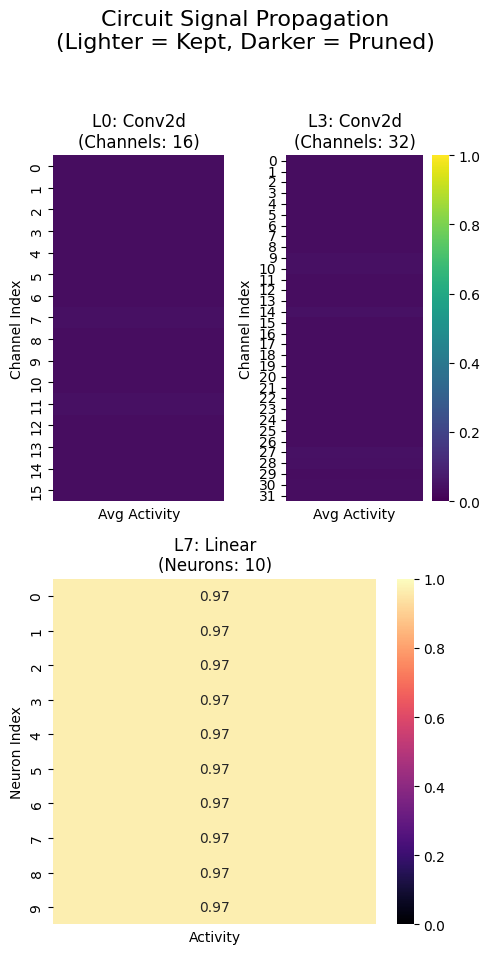


Visualization saved to circuit_visualization.png
Saved visualization to: circuit_viz_class_0.png


In [29]:
circuit_0 = run_class_circuit(class_idx=0, model=model, epochs=20,l0_lambda=8e+2, lr=1e-1, mean_ablation=True)

In [30]:
trainloader, testloader = train.load_dataset("mnist-baseline")

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [31]:
circuit_0.mean_ablation

True

In [32]:
circuit_0.mean_ablation = False

In [36]:
invert_masks(circuit_0)

In [37]:
active_neurons(circuit_0)

tensor([ 5672,  5790,  5900,  6056,  6057,  6058,  6114,  8968,  8970,  8971,
         9023,  9025, 14344, 14570, 15432, 15433, 17924, 17925, 18153],
       device='cuda:0')

In [38]:
class_wise_acc(circuit_0, testloader, [0,1,2,3,4,5,6,7,8,9], device)

{0: tensor(1., device='cuda:0'),
 1: tensor(0., device='cuda:0'),
 2: tensor(0., device='cuda:0'),
 3: tensor(0., device='cuda:0'),
 4: tensor(0., device='cuda:0'),
 5: tensor(0., device='cuda:0'),
 6: tensor(0., device='cuda:0'),
 7: tensor(0., device='cuda:0'),
 8: tensor(0., device='cuda:0'),
 9: tensor(0., device='cuda:0')}

In [24]:
neurons = active_neurons(circuit_0)

In [25]:
invert_masks(circuit_0)
toggle_neurons(circuit_0, neurons)

for neuron in neurons[:10]:
    toggle_neurons(circuit_0, [neuron])
    print(class_wise_acc(circuit_0, testloader, [0,1,2,3,4,5,6,7,8,9], device))


/kaggle/working/utils.py:71: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  full_vector[idxs] *= -1


{0: tensor(0.8112, device='cuda:0'), 1: tensor(0.9480, device='cuda:0'), 2: tensor(0.7839, device='cuda:0'), 3: tensor(0.7525, device='cuda:0'), 4: tensor(0.7790, device='cuda:0'), 5: tensor(0.6861, device='cuda:0'), 6: tensor(0.8518, device='cuda:0'), 7: tensor(0.7461, device='cuda:0'), 8: tensor(0.7485, device='cuda:0'), 9: tensor(0.8731, device='cuda:0')}
{0: tensor(0.8112, device='cuda:0'), 1: tensor(0.9480, device='cuda:0'), 2: tensor(0.7839, device='cuda:0'), 3: tensor(0.7525, device='cuda:0'), 4: tensor(0.7790, device='cuda:0'), 5: tensor(0.6861, device='cuda:0'), 6: tensor(0.8518, device='cuda:0'), 7: tensor(0.7461, device='cuda:0'), 8: tensor(0.7485, device='cuda:0'), 9: tensor(0.8731, device='cuda:0')}
{0: tensor(0.8112, device='cuda:0'), 1: tensor(0.9480, device='cuda:0'), 2: tensor(0.7839, device='cuda:0'), 3: tensor(0.7525, device='cuda:0'), 4: tensor(0.7790, device='cuda:0'), 5: tensor(0.6861, device='cuda:0'), 6: tensor(0.8518, device='cuda:0'), 7: tensor(0.7461, device=

 Processing Class 1 
Configuration: Device=cuda, Lambda=800.0, Dataset=mnist-class-1


/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Calculating mean activations...
Initializing Circuit...
Initializing Optimizer...
Extracting Circuit (L0 Lambda=800.0)...
Epoch 0 | Loss: 602.2424 | Avg Mask: -0.416 | Total Non-Zero: 35.0 | | Circuit Acc: 0.9806
Epoch 1 | Loss: 1.5629 | Avg Mask: -0.997 | Total Non-Zero: 29.0 | | Circuit Acc: 0.9864
Epoch 2 | Loss: 1.4274 | Avg Mask: -0.997 | Total Non-Zero: 26.0 | | Circuit Acc: 0.9911
Epoch 3 | Loss: 1.3086 | Avg Mask: -0.997 | Total Non-Zero: 24.0 | | Circuit Acc: 0.9911
Epoch 4 | Loss: 1.3086 | Avg Mask: -0.997 | Total Non-Zero: 24.0 | | Circuit Acc: 0.9899
Epoch 5 | Loss: 1.3108 | Avg Mask: -0.997 | Total Non-Zero: 25.0 | | Circuit Acc: 0.9911
Epoch 6 | Loss: 1.3167 | Avg Mask: -0.997 | Total Non-Zero: 24.0 | | Circuit Acc: 0.9911
Epoch 7 | Loss: 1.3282 | Avg Mask: -0.997 | Total Non-Zero: 24.0 | | Circuit Acc: 0.9911
Epoch 8 | Loss: 1.3335 | Avg Mask: -0.997 | Total Non-Zero: 25.0 | | Circuit Acc: 0.9911
Epoch 9 | Loss: 1.3221 | Avg Mask: -0.997 | Total Non-Zero: 24.0 | | Circui

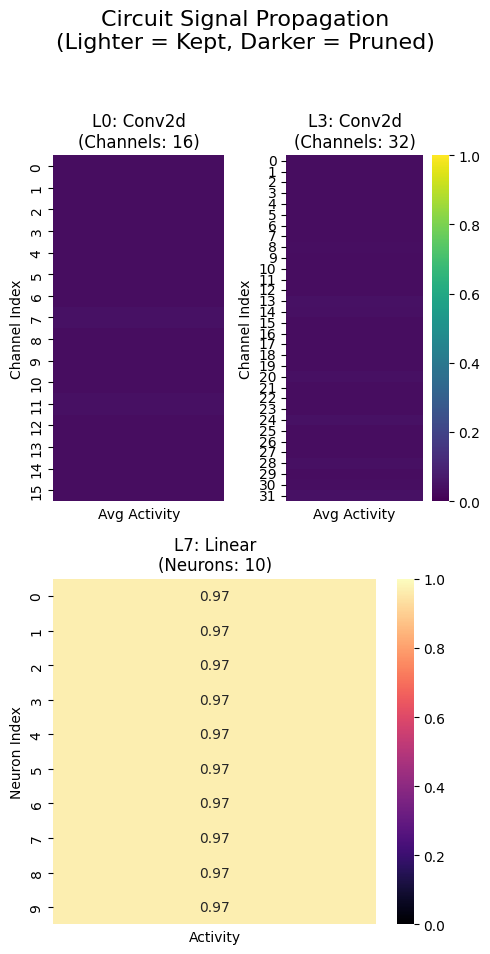


Visualization saved to circuit_visualization.png
Saved visualization to: circuit_viz_class_1.png


In [39]:
circuit_1 = run_class_circuit(class_idx=1, model=model, epochs=10,l0_lambda=8e+2, lr=1e-1, mean_ablation=True)

In [43]:
invert_masks(circuit_1)

In [44]:
active_neurons(circuit_1)

tensor([ 5782,  5811,  5948,  5949,  5950,  5951,  6004,  6005,  8918,  8919,
         8920,  8947,  9030,  9031, 15210, 15211, 15365, 16556, 17310, 17311,
        18177, 18738, 18739], device='cuda:0')

In [45]:
class_wise_acc(circuit_1, testloader, [0,1,2,3,4,5,6,7,8,9], device)

{0: tensor(0., device='cuda:0'),
 1: tensor(0.9877, device='cuda:0'),
 2: tensor(0.2190, device='cuda:0'),
 3: tensor(0.6564, device='cuda:0'),
 4: tensor(0., device='cuda:0'),
 5: tensor(0., device='cuda:0'),
 6: tensor(0., device='cuda:0'),
 7: tensor(0., device='cuda:0'),
 8: tensor(0., device='cuda:0'),
 9: tensor(0.1368, device='cuda:0')}

In [48]:
circuits_dict = {0: circuit_0, 1: circuit_1}

 Analysis: Circuit Overlay (Layer 0) 


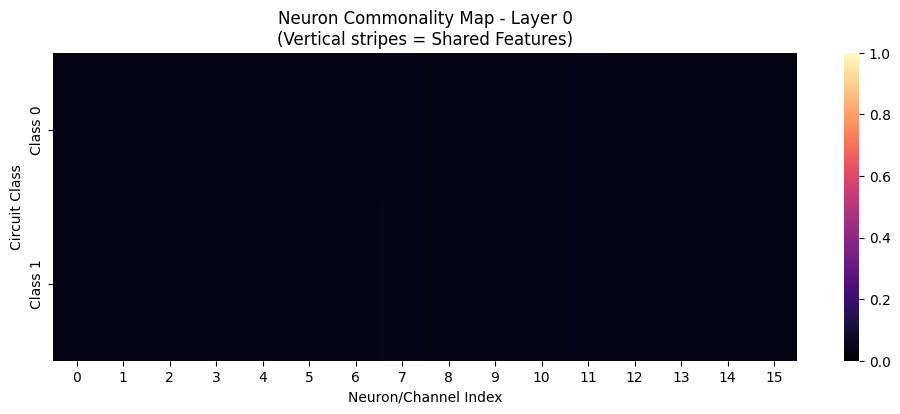

Layer 0 Stats:
 - Total Neurons/Channels: 16
 - Universally Shared Neurons (Used by all): 0 indices: []
 - Class-Specific Neurons (Used by exactly 1): 0


array([], dtype=int64)

In [53]:
ce.analyze_circuit_overlay(circuits_dict, layer_idx=0)

 Analysis: Circuit Overlay (Layer 3) 


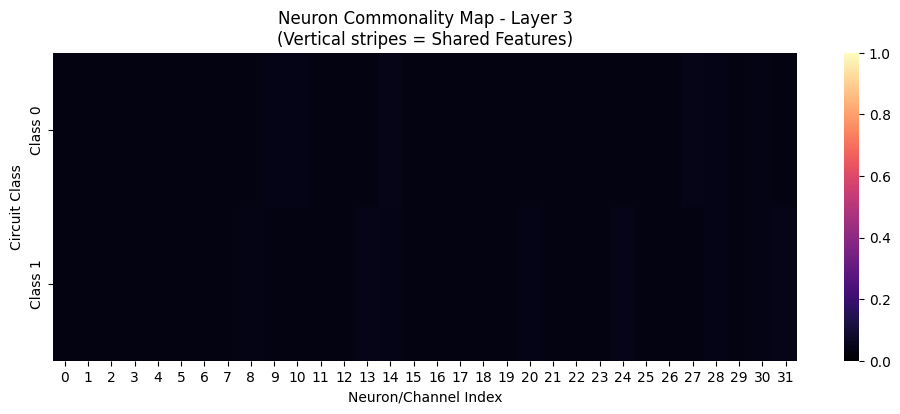

Layer 3 Stats:
 - Total Neurons/Channels: 32
 - Universally Shared Neurons (Used by all): 0 indices: []
 - Class-Specific Neurons (Used by exactly 1): 0


array([], dtype=int64)

In [54]:
ce.analyze_circuit_overlay(circuits_dict, layer_idx=3)

In [ ]:
circuit_2 = run_class_circuit(2, model)

In [ ]:
circuit_3 = run_class_circuit(3, model)

In [ ]:
circuit_4 = run_class_circuit(4, model)

In [ ]:
circuit_5 = run_class_circuit(5, model)

In [ ]:
circuit_6 = run_class_circuit(6, model)

In [ ]:
circuit_7 = run_class_circuit(7, model)

In [ ]:
circuit_8 = run_class_circuit(8, model)

In [ ]:
circuit_9 = run_class_circuit(9, model)

### Finetuned layer

In [ ]:
print("\n--- Phase 2: Train Sparse Baseline ---")
train.finetune(
    model=model,
    num_classes=2,
    lr=cfg['baseline']['lr'],
    b1=0.9, b2=0.999,
    ds_name="mnist-circuit",
    eps=1e-8,
    epochs=cfg['baseline']['epochs'],
    device=device,
    seed=cfg['seed']
)


--- Phase 2: Train Sparse Baseline ---
n_params 23628 n_params_wd 23568


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0 | Train Acc: 0.9357 | Test Acc: 0.9456
Epoch 1 | Train Acc: 0.9511 | Test Acc: 0.9550
Epoch 2 | Train Acc: 0.9436 | Test Acc: 0.9498
